# Importação dos dados e carregamento dos pacotes

In [75]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy.stats import poisson
import statsmodels.api as sm
from statsmodels.graphics import tsaplots
import matplotlib.pyplot as plt
from matplotlib import pyplot
from statsmodels.tsa.seasonal import seasonal_decompose

In [27]:
df = pd.read_csv('ia_vende_normalmente.csv', delimiter= ';', index_col=[0])

# Explorações Iniciais

In [28]:
df.head()

,cliente_id,nome_cliente,data_hora_venda,valor_venda,Unnamed: 5
venda_id,,,,,
1,17012022,IA Blu Ltda,17/01/2018 09:00,"R$ 171,04",NaN
2,17012022,IA Blu Ltda,22/01/2018 12:52,"R$ 80,57",NaN
3,17012022,IA Blu Ltda,27/01/2018 18:33,"R$ 83,79",NaN
4,17012022,IA Blu Ltda,01/02/2018 17:27,"R$ 77,94",NaN
5,17012022,IA Blu Ltda,09/02/2018 08:57,"R$ 147,15",NaN


In [29]:
df.columns

Index(['cliente_id', 'nome_cliente', 'data_hora_venda', ' valor_venda ',
       'Unnamed: 5'],
      dtype='object')

Aqui notamos que a coluna valor_venda está com espaços extras, o que será um incômodo, logo vamos formatar esse nome de coluna. Notamos também uma coluna estranha ao final, contendo apenas valores nulos, a qual eliminaremos. 

In [30]:
df.rename(columns={' valor_venda ':'valor_venda'}, inplace= True)

In [31]:
df = df.drop('Unnamed: 5', axis = 1)

In [32]:
df.head()

,cliente_id,nome_cliente,data_hora_venda,valor_venda
venda_id,,,,
1,17012022,IA Blu Ltda,17/01/2018 09:00,"R$ 171,04"
2,17012022,IA Blu Ltda,22/01/2018 12:52,"R$ 80,57"
3,17012022,IA Blu Ltda,27/01/2018 18:33,"R$ 83,79"
4,17012022,IA Blu Ltda,01/02/2018 17:27,"R$ 77,94"
5,17012022,IA Blu Ltda,09/02/2018 08:57,"R$ 147,15"


In [33]:
df.dtypes

cliente_id          int64
nome_cliente       object
data_hora_venda    object
valor_venda        object
dtype: object

Notamos que a coluna de data não está como timestamp/datetime, portanto iremos convertê-la. 
Analogamente, a coluna valor_venda está como object/string, portanto a transformaremos em número/float.

In [34]:
# convertendo data para datetime
df['data_hora_venda'] = pd.to_datetime(df['data_hora_venda'], dayfirst=True)

In [35]:
# covertendo valor para número (float)
df.valor_venda = df.valor_venda.str.replace('R$ ','') # removendo unidade monetária
df.valor_venda = df.valor_venda.str.replace(',','.') # trocando vírgula para ponto como separador de decimal
df.valor_venda = pd.to_numeric(df.valor_venda)

In [36]:
df.dtypes

cliente_id                  int64
nome_cliente               object
data_hora_venda    datetime64[ns]
valor_venda               float64
dtype: object

In [37]:
df.nome_cliente.value_counts()

nome_cliente
IA Blu Ltda    293
Name: count, dtype: int64

In [38]:
df.cliente_id.value_counts()

cliente_id
17012022    293
Name: count, dtype: int64

Notemos que as colunas nome_cliente e cliente_id possuem apenas um único valor, portanto não são informativas e as eliminaremos da análise

In [39]:
df = df.drop(['nome_cliente', 'cliente_id'], axis = 1)

In [40]:
df.head()

,data_hora_venda,valor_venda
venda_id,,
1,2018-01-17 09:00:00,171.04
2,2018-01-22 12:52:00,80.57
3,2018-01-27 18:33:00,83.79
4,2018-02-01 17:27:00,77.94
5,2018-02-09 08:57:00,147.15


# Perguntas

## Estime a probabilidade deste cliente ficar 29 dias consecutivos sem vender. Justifique o procedimento escolhido para realizar a estimativa.

Precisamos saber como é a distribuição dos dias entre as vendas

In [46]:
df['dias_sem_vender'] = df.data_hora_venda.diff().dt.days

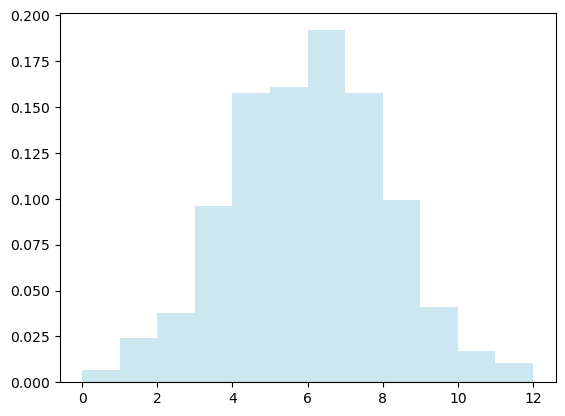

In [88]:
plt.hist(df['dias_sem_vender'], bins=range(0, 13), density=True, alpha=0.6, color='lightblue');

Como a quantidade de dias entre as vendas é uma contagem, vamos estimar uma distribuição de Poisson com os dados dessa diferença

In [50]:
diffs = df.dias_sem_vender.dropna()

lambda_poisson = np.mean(diffs)

lambda_poisson

5.523972602739726

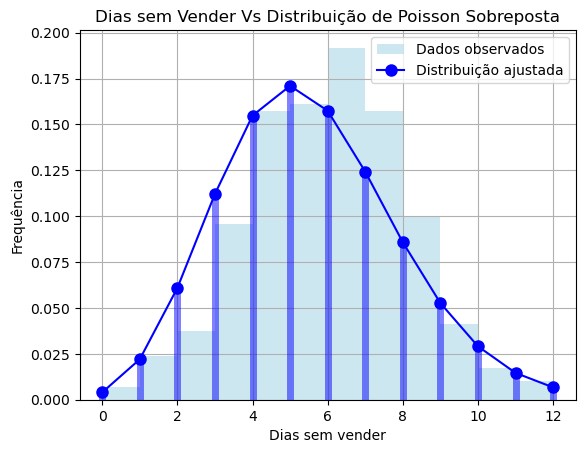

In [93]:
plt.hist(df['dias_sem_vender'], bins=range(0, 13), density=True, alpha=0.6, color='lightblue', label='Dados observados');

poisson_pmf = poisson.pmf(np.arange(0, 13), lambda_poisson)

# Plotar a distribuição de Poisson
plt.plot(x, poisson_pmf, 'bo-', ms=8, label='Distribuição ajustada')
plt.vlines(x, 0, poisson_pmf, colors='b', lw=5, alpha=0.5)

# Adicionar rótulos e título
plt.xlabel('Dias sem vender')
plt.ylabel('Frequência')
plt.legend()
plt.title('Dias sem Vender Vs Distribuição de Poisson Sobreposta')

# Mostrar o gráfico
plt.grid(True)
plt.show()

In [80]:
poisson.cdf(29, lambda_poisson)

0.9999999999996616

In [67]:
poisson_dist = stats.poisson(mu=lambda_poisson)
print(f"Probabilidade de  dias: {poisson_dist.pmf(29)}")

Probabilidade de  dias: 1.5126007887181281e-12


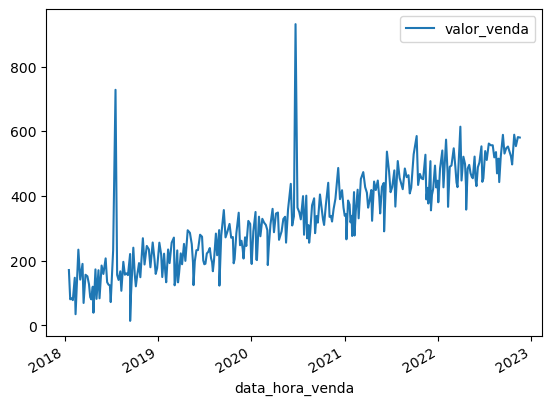

In [41]:
df.plot.line('data_hora_venda', 'valor_venda');

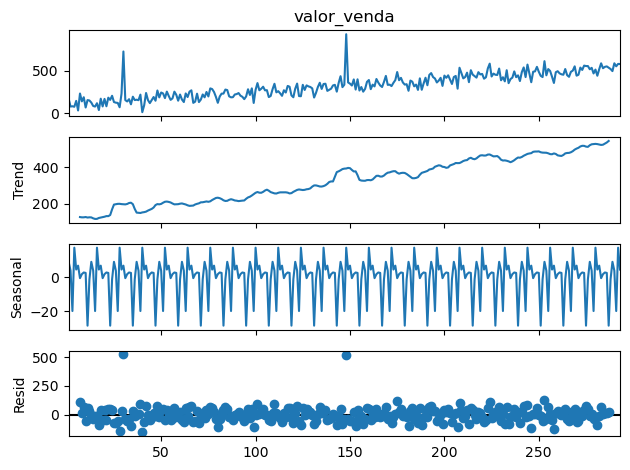

In [42]:
result = seasonal_decompose(df.valor_venda, model='additive', period=12)
result.plot()
pyplot.show()

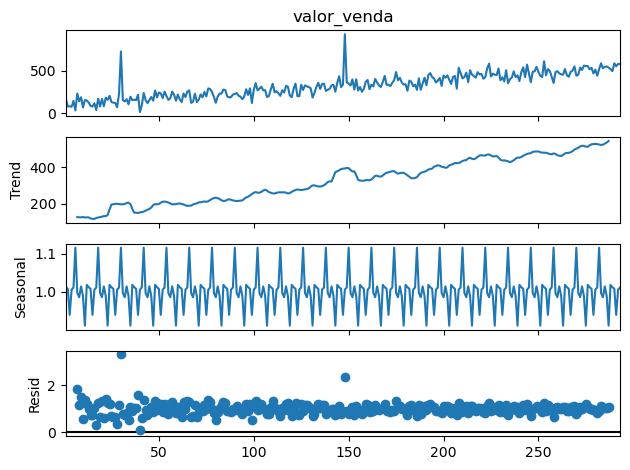

In [43]:
result = seasonal_decompose(df.valor_venda, model='multiplicative', period=12)
result.plot()
pyplot.show()